<a href="https://colab.research.google.com/github/Sougotadayglo/Self-supervised_Topic_classification/blob/main/Topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


use tensorflow version 1.15 while using the bert-serving-client and then upgrade the version

In [ ]:
pip install --upgrade tensorflow

  Using cached tensorflow-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl (454.3 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [ ]:
# import all the modules required for executing the program

import pandas as pd
from pprint import pprint
import re
import numpy as np
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import gensim
from gensim.utils import simple_preprocess

import spacy

from keras.models import Sequential
from keras import layers
from keras import callbacks

import nltk
from nltk.corpus import stopwords


In [ ]:
# load the LDA model that has been saved earlier in Topic Modeling
lda_model = gensim.models.ldamodel.LdaModel.load('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/lda_model.model')

In [ ]:
# annotating the topics based on the topic clusters that we have got from our LDA model that
# best represent the topic description. Creating a dictionary where the key represent the
# topic number and the value represent the actual topic.

topic_from_topic_cluster = {}

topic_from_topic_cluster[0]  = 'wait time'
topic_from_topic_cluster[1]  = 'delivery punctuality'
topic_from_topic_cluster[2]  = 'discount'
topic_from_topic_cluster[3]  = 'garage service'
topic_from_topic_cluster[4]  = 'change of date, booking confusion'
topic_from_topic_cluster[5]  = 'garage service'
topic_from_topic_cluster[6]  = 'value for money'
topic_from_topic_cluster[7]  = 'tire quality'
topic_from_topic_cluster[8]  = 'garage service'
topic_from_topic_cluster[9]  = 'ease of booking'
topic_from_topic_cluster[10] = 'mobile fitter'
topic_from_topic_cluster[11] = 'length of fitting'
topic_from_topic_cluster[12] = 'value for money'
topic_from_topic_cluster[13] = 'tyre quality'
topic_from_topic_cluster[14] = 'ease of booking'

In [ ]:
# loading the dataset saved after modeling the topics. This dataset will be used as the training and testing set for classification
# use dataset : "annotated_dataset_multi_label_dl.csv" for multi-label
# use dataset : "annotated_dataset_multi_class.csv" for multi-class

annotated_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/annotated_dataset_multi_label.csv')

In [ ]:
pprint(annotated_df['Text'][0])
annotated_df.head()

('Tires where delivered to the garage of my choice,the garage notified me when '
 'they had been delivered. A day and time was arranged with the garage and I '
 'went and had them fitted,a Hassel free experience.')


,Document_No,Label1,Label2,Label3,Label4,Label5,Label6,Label7,Label8,Label9,Label10,Label11,Label12,Label13,Label14,Label15,Text
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,Tires where delivered to the garage of my choi...
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"Easy Tyre Selection Process, Competitive Prici..."
2,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,Very easy to use and good value for money.
3,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Really easy and convenient to arrange
4,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,It was so easy to select tyre sizes and arrang...


# **Pre-processing**


In [ ]:
# Remove stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

for i in tqdm(range(100)):
    try:
        annotated_df['Text'][i] = ' '.join([word for word in annotated_df['Text'][i].split() if word not in (stop)])
    except:
        pass

annotated_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Document_No,Label1,Label2,Label3,Label4,Label5,Label6,Label7,Label8,Label9,Label10,Label11,Label12,Label13,Label14,Label15,Text
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,"Tires delivered garage choice,the garage notif..."
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"Easy Tyre Selection Process, Competitive Prici..."
2,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,Very easy use good value money.
3,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Really easy convenient arrange
4,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,It easy select tyre sizes arrange local fittin...


In [ ]:
def simple_process(text):
    process_text = gensim.utils.simple_preprocess(text, deacc=True)
    text = ' '.join([word for word in process_text])
    return text

def clean_text(text):
    """
    Removes unuseful data from the text like URLs, punctuations, symbols etc.

    Parameters:
    ----------
    text : the sentence to be cleaned

    Returns:
    -------
    cleaned text
    """
    
    # remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # taking sequences of characters with alphanumeric characters separated by other characters
    text = re.sub(r"[-?!&]",' ',text)
    text = re.sub(r'''["#$%()*+,./:;<=>@[\]^_`{|}~]''','',text)
    
    # remove all numeric charracters
    text = re.sub(r'[0-9]','',text)

    # Remove new line characters
    text = re.sub(r'\s+', ' ', text)

    # remove all numeric charracters
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '',text)

    Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}
  
    #replace the contractions
    for key,value in Apos_dict.items():
        if key in text:
            text=text.replace(key,value)

    # convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation

    Lemmatize the text using the allowed POS tags

    Parameters:
    ----------
    text            : the sentence to be cleaned
    allowed_postags : the POS tags that are allowed in the text.

    Returns:
    -------
    lemmatized text
    """
    
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Parse the sentence using the loaded 'en' model object `nlp`
    doc = nlp(texts)

    text = ' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text


In [ ]:
# Clean and lemmatized all the documents in the dataframe.
# This step can be omitted as we have already pre-processed the text in the Topic modeling


for i in tqdm(range(100)):
    annotated_df['Text'][i] = simple_process(annotated_df['Text'][i])
    #annotated_df['Text'][i] = clean_text(annotated_df['Text'][i])         # skipped as already cleaned in topic modeling 
    annotated_df['Text'][i] = lemmatization(annotated_df['Text'][i])

#annotated_df.dropna(inplace=True)
annotated_df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Document_No,Label1,Label2,Label3,Label4,Label5,Label6,Label7,Label8,Label9,Label10,Label11,Label12,Label13,Label14,Label15,Text
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,tire deliver garage choice garage notify deliv...
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,selection process competitive pricing excellen...
2,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,very easy use good value money
3,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,really easy convenient arrange
4,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,easy select size arrange local fit price compe...


In [ ]:
# split into training and validation sets
train, test = train_test_split(annotated_df, random_state=42, test_size=0.15)

X_train = train.Text
X_test  = test.Text
y_train = train.drop(labels = ['Document_No','Text'], axis=1).to_numpy()
y_test  = test.drop(labels = ['Document_No','Text'], axis=1).to_numpy()

## **Bert-serving-client**
BERT is a NLP model developed by Google for pre-training language representations. It leverages an enormous amount of plain text data publicly available on the web and is trained in an unsupervised manner. Pre-training a BERT model is a fairly expensive yet one-time procedure for each language. Fortunately, Google released several pre-trained models where you can download from here.

Sentence Encoding/Embedding is a upstream task required in many NLP applications, e.g. sentiment analysis, text classification. The goal is to represent a variable length sentence into a fixed length vector, e.g. hello world to [0.1, 0.3, 0.9]. Each element of the vector should “encode” some semantics of the original sentence.

Finally, bert-as-service uses BERT as a sentence encoder and hosts it as a service via ZeroMQ, allowing you to map sentences into fixed-length representations in just two lines of code.

Here we have used bert-as-client to generate sentence embeddings from pre-trained bert that we can use as embedding vector for our classification purpose.

### connect to a GPU runtime if using bert-serving-client.

In [ ]:
pip install -U bert-serving-server bert-serving-client

     |████████████████████████████████| 61 kB 301 kB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=0c9bf60ff85f5f92925eb38e8dd34c1cecf9be82182b29e0cb3dcff3c012848a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip

--2021-07-22 10:45:46--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   101MB/s    in 3.8s    

2021-07-22 10:45:50 (101 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
!nohup bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 512 > out.file 2>&1 &

**You can avoid these steps to generate the encodings if you want as I have already trained the bert model and saved the encodings for both training and testing data. You can directly use them.**

#============================================================================================================================================================================================================================================================================================#

In [ ]:
from bert_serving.client import BertClient

X_train_bert = []
bc = BertClient()

for i in tqdm(range(8610)):
    temp = bc.encode(X_train[i:i+1].to_list())
    X_train_bert.append(temp[0])

X_train_bert = np.array(X_train_bert)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/trainTopicModelingBERTWordEmbeddings.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_train_bert, filehandle)


/usr/local/lib/python3.7/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [ ]:
X_val_bert = []

for i in tqdm(range(1520)):
    temp = bc.encode(X_val[i:i+1].to_list())
    X_val_bert.append(temp[0])
X_val_bert = np.array(X_val_bert)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/testTopicModelingBERTWordEmbeddings.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(X_val_bert, filehandle)

#============================================================================================================================================================================================================================================================================================#

Read the sentence encodings for training and testing data.

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/trainTopicModelingBERTWordEmbeddings.data', 'rb') as filehandle:
    # read the data as binary data stream
    X_train_bert = pickle.load(filehandle)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/testTopicModelingBERTWordEmbeddings.data', 'rb') as filehandle:
    # store the data as binary data stream
    X_val_bert = pickle.load(filehandle)

In [ ]:
# normalize the training and testing data
X_train_bert = preprocessing.normalize(X_train_bert)
X_val_bert = preprocessing.normalize(X_val_bert)

In [ ]:
# standardize the testing and training data
scaler_Xtrain_bert = preprocessing.StandardScaler().fit(X_train_bert)
scaler_Xval_bert = preprocessing.StandardScaler().fit(X_val_bert)

X_train_bert_scaled = scaler_Xtrain_bert.transform(X_train_bert)
X_val_bert_scaled = scaler_Xval_bert.transform(X_val_bert)

In [ ]:
print(X_train_bert_scaled.shape)

(8610, 768)


In [ ]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

# **Multi - Label Classification of topics**
Can classify more than one topics per document

In [ ]:
def create_model():
    input_dim = X_train_bert_scaled.shape[1]  # Number of features

    model = Sequential()
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(15, activation='sigmoid')) # activation = {sigmoid (for multi-label) ; softmax (for multi-class)} 

    # use binary_crossentropy for multi-label classification (classify more than one topics per document)
    # use categorical_crossentropy for multi-class classification (classify one topic per document)
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = create_model()
earlyStopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=12)
modelCheckpoint = callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NeuralN_multi_label.hdf5',
                                            save_best_only=True, monitor='val_accuracy', mode='max')
#reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, min_lr=0.001)
history = model.fit(X_train_bert_scaled, y_train,
                    epochs=80,
                    validation_data=(X_val_bert_scaled, y_test),
                    batch_size=100, callbacks=[earlyStopping,modelCheckpoint])

Epoch 1/80
87/87 [==============================] - 17s 22ms/step - loss: 0.3910 - accuracy: 0.2025 - val_loss: 0.2304 - val_accuracy: 0.3980
Epoch 2/80
87/87 [==============================] - 1s 15ms/step - loss: 0.2327 - accuracy: 0.3705 - val_loss: 0.2124 - val_accuracy: 0.3980
Epoch 3/80
87/87 [==============================] - 1s 15ms/step - loss: 0.2113 - accuracy: 0.4100 - val_loss: 0.1994 - val_accuracy: 0.4368
Epoch 4/80
87/87 [==============================] - 1s 15ms/step - loss: 0.1964 - accuracy: 0.4438 - val_loss: 0.1916 - val_accuracy: 0.4395
Epoch 5/80
87/87 [==============================] - 1s 16ms/step - loss: 0.1862 - accuracy: 0.4659 - val_loss: 0.1864 - val_accuracy: 0.4500
Epoch 6/80
87/87 [==============================] - 1s 15ms/step - loss: 0.1774 - accuracy: 0.4835 - val_loss: 0.1824 - val_accuracy: 0.4783
Epoch 7/80
87/87 [==============================] - 1s 16ms/step - loss: 0.1696 - accuracy: 0.4926 - val_loss: 0.1808 - val_accuracy: 0.4645
Epoch 8/80
8

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


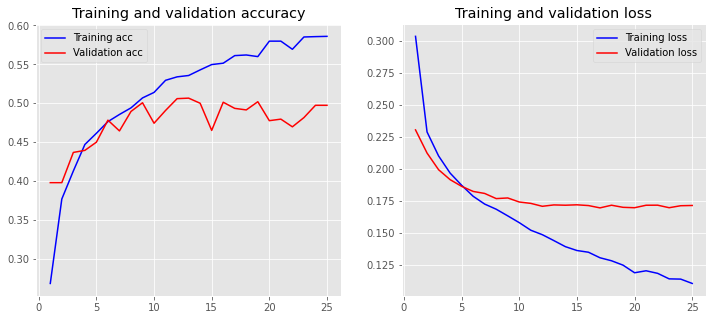

In [ ]:
plot_history(history)

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NeuralN_multi_label.hdf5')
print(np.round(model.predict(X_val_bert_scaled)[0:4]))
print(model.predict_classes(X_val_bert_scaled)[0:4])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[7 0 0 4]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# testing our model with real time texts.

def check_multi_topics_dl(text, X_val):
    model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NeuralN_multi_label.hdf5')
    
    for i in range(0,10):

        X_test = np.array([X_val[i]])
        #print(X_test)
        pred = np.round(model.predict(X_test))
        j = 0
        list_topics_num = []
        for labels in pred[0]:
            if labels==1.0:
                list_topics_num.append(j)
            j+=1
        print("The topics for the text : ", text[i:i+1].tolist()[0], " are ::::::")
        for topics_num in list_topics_num:
            print('--------------',topic_from_topic_cluster[topics_num], '---------------')

check_multi_topics_dl(X_test, X_val_bert_scaled)

The topics for the text :  Took my money could not supply mybad news. Took my money could not supply my correct tyre and never replied to four emails  are ::::::
-------------- tire quality ---------------
The topics for the text :  Excellent price, superb service. Chose to have tyres fitted at home, fitters confirmed booking, then called to see if an earlier appointment could suit as tyres arrived early, polite, professional and not at all pushy.  are ::::::
The topics for the text :  I have used you in the past and had excellent service, the past company I had the tyres fitted at were excellent, but no longer one of your options for fitting now. I chose your premium fitter in Basingstoke, Formula One Auto - and they were awful. Their customer service was non existent. I phoned up and got a quote for having the wheels tracked, they quoted £ for front and £ for front and back if needed, but I probably only had the fronts that it was possible to do. With this I sent my husband to have t

# **Multi-label classification using Classifier Chains**
A type of multi-label classification in which a chain of binary classifiers C0, C1, . . . , Cn is constructed, where a classifier Ci uses the predictions of all the classifier Cj , where j < i. This way the method, also called classifier chains (CC), can take into account label correlations.
The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved.

https://arxiv.org/abs/1912.13405

In [ ]:
# using classifier chains

# initialize classifier chains multi-label classifiers
LogisticRegressionClassifier = ClassifierChain(LogisticRegression(max_iter=1000))
NaiveBayesClassifier         = ClassifierChain(GaussianNB())
SVMClassifier                = ClassifierChain(LinearSVC(dual=False, max_iter=2000))


# Training the models on train data
LogisticRegressionClassifier.fit(X_train_bert_scaled, y_train)
NaiveBayesClassifier.fit(X_train_bert_scaled, y_train)
SVMClassifier.fit(X_train_bert_scaled, y_train)

# predict
LRpredictions = LogisticRegressionClassifier.predict(X_val_bert_scaled)
NBpredictions = NaiveBayesClassifier.predict(X_val_bert_scaled)
SVMpredictions = SVMClassifier.predict(X_val_bert_scaled)

# accuracy
print("Logistic Regtession Accuracy = ", accuracy_score(y_test,LRpredictions))
print("Naive Bayes Accuracy = ", accuracy_score(y_test,NBpredictions))
print("SVM Accuracy = ", accuracy_score(y_test,SVMpredictions))

Logistic Regtession Accuracy =  0.3368421052631579
Naive Bayes Accuracy =  0.02236842105263158
SVM Accuracy =  0.30723684210526314


In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/LR_multiLabelModel.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(LogisticRegressionClassifier, filehandle)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NB_multiLabelModel.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(NaiveBayesClassifier, filehandle)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/SVM_multiLabelModel.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(SVMClassifier, filehandle)


In [ ]:
def check_multi_topics_ml(text, X_val):
    with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/LR_multiLabelModel.pkl', 'rb') as file:
        classifier = pickle.load(file)
    #classifier = LogisticRegressionClassifier
    for i in range(10):

        X_test = np.array([X_val[i]])
        #print(X_test)
        pred = classifier.predict(X_test)
        j = 0
        list_topics_num = []
        for labels in pred[0]:
            if labels==1.0:
                list_topics_num.append(j)
            j+=1
        print("The topics for the text : ", text[i:i+1].tolist()[0], " are ::::::")
        for topics_num in list_topics_num:
            print('--------------',topic_from_topic_cluster[topics_num], '---------------')

check_multi_topics_ml(X_test, X_val_bert_scaled)

The topics for the text :  Took my money could not supply mybad news. Took my money could not supply my correct tyre and never replied to four emails  are ::::::
-------------- wait time ---------------
-------------- tire quality ---------------
The topics for the text :  Excellent price, superb service. Chose to have tyres fitted at home, fitters confirmed booking, then called to see if an earlier appointment could suit as tyres arrived early, polite, professional and not at all pushy.  are ::::::
-------------- mobile fitter ---------------
-------------- tyre quality ---------------
The topics for the text :  I have used you in the past and had excellent service, the past company I had the tyres fitted at were excellent, but no longer one of your options for fitting now. I chose your premium fitter in Basingstoke, Formula One Auto - and they were awful. Their customer service was non existent. I phoned up and got a quote for having the wheels tracked, they quoted £ for front and £ 

# **Multi - Class Topic Classification:**

Can classify the most dominant topic for a perticular document

In [ ]:
# loading the dataset saved after modeling the topics. This dataset will be used as the training and testing set for classification
# use dataset : "annotated_dataset_multi_label_dl.csv" for multi-label
# use dataset : "annotated_dataset_multi_class.csv" for multi-class

annotated_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/annotated_dataset_multi_class.csv')

In [ ]:
# split into training and validation sets
train, test = train_test_split(annotated_df, random_state=42, test_size=0.15)

X_train = train.Text
X_test  = test.Text
y_train = train.drop(labels = ['Document_No','Text'], axis=1).to_numpy()
y_test  = test.drop(labels = ['Document_No','Text'], axis=1).to_numpy()

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/trainTopicModelingBERTWordEmbeddings.data', 'rb') as filehandle:
    # read the data as binary data stream
    X_train_bert = pickle.load(filehandle)

with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/testTopicModelingBERTWordEmbeddings.data', 'rb') as filehandle:
    # store the data as binary data stream
    X_val_bert = pickle.load(filehandle)

In [ ]:
# normalize the training and testing data
X_train_bert = preprocessing.normalize(X_train_bert)
X_val_bert = preprocessing.normalize(X_val_bert)

In [ ]:
# standardize the testing and training data
scaler_Xtrain_bert = preprocessing.StandardScaler().fit(X_train_bert)
scaler_Xval_bert = preprocessing.StandardScaler().fit(X_val_bert)

X_train_bert_scaled = scaler_Xtrain_bert.transform(X_train_bert)
X_val_bert_scaled = scaler_Xval_bert.transform(X_val_bert)

In [ ]:
def create_multiclass_model():
    input_dim = X_train_bert_scaled.shape[1]  # Number of features

    model = Sequential()
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(15, activation='softmax')) # activation = {sigmoid (for multi-label) ; softmax (for multi-class)} 

    # use binary_crossentropy for multi-label classification (classify more than one topics per document)
    # use categorical_crossentropy for multi-class classification (classify one topic per document)
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = create_multiclass_model()
earlyStopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=12)
modelCheckpoint = callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NeuralN_multi_class.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
#reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, min_lr=0.001)
history = model.fit(X_train_bert_scaled, y_train,
                    epochs=80,
                    validation_data=(X_val_bert_scaled, y_test),
                    batch_size=10, callbacks=[earlyStopping,modelCheckpoint])

Epoch 1/80
861/861 [==============================] - 8s 8ms/step - loss: 2.0966 - accuracy: 0.3509 - val_loss: 1.5895 - val_accuracy: 0.4803
Epoch 2/80
861/861 [==============================] - 6s 7ms/step - loss: 1.6290 - accuracy: 0.4612 - val_loss: 1.4788 - val_accuracy: 0.5289
Epoch 3/80
861/861 [==============================] - 7s 8ms/step - loss: 1.5141 - accuracy: 0.5088 - val_loss: 1.4420 - val_accuracy: 0.5303
Epoch 4/80
861/861 [==============================] - 6s 7ms/step - loss: 1.4170 - accuracy: 0.5323 - val_loss: 1.3801 - val_accuracy: 0.5592
Epoch 5/80
861/861 [==============================] - 6s 7ms/step - loss: 1.3409 - accuracy: 0.5591 - val_loss: 1.3868 - val_accuracy: 0.5651
Epoch 6/80
861/861 [==============================] - 7s 8ms/step - loss: 1.2837 - accuracy: 0.5753 - val_loss: 1.3599 - val_accuracy: 0.5605
Epoch 7/80
861/861 [==============================] - 6s 7ms/step - loss: 1.2240 - accuracy: 0.5925 - val_loss: 1.3434 - val_accuracy: 0.5625
Epoch 

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

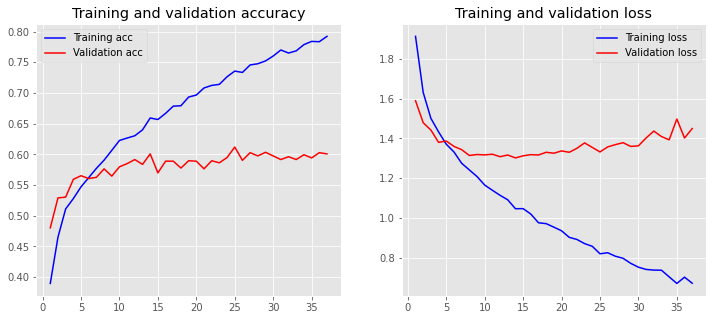

In [ ]:
plot_history(history)

In [ ]:
def check_dominant_topic(text, X_val):

    # load the model from the file for multiclass classification
    model = keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/NeuralN_multi_class.hdf5')

    for i in range(10):

        pred = model.predict_classes(np.array([X_val[i]]))
        print("The dominant topic for the text :  ", text[i:i+1].tolist()[0], ' is ::: \n-------------',
              topic_from_topic_cluster[pred[0]],'-------------\n')

check_dominant_topic(X_test, X_val_bert_scaled)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The dominant topic for the text :   Took my money could not supply mybad news. Took my money could not supply my correct tyre and never replied to four emails  is ::: 
------------- wait time -------------

The dominant topic for the text :   Excellent price, superb service. Chose to have tyres fitted at home, fitters confirmed booking, then called to see if an earlier appointment could suit as tyres arrived early, polite, professional and not at all pushy.  is ::: 
------------- wait time -------------

The dominant topic for the text :   I have used you in the past and had excellent service, the past company I had the tyres fitted at were excellent, but no longer one of your options for fitting now. I chose your premium fitter in Basingstoke, Formula One Auto - and they were awful. Their customer service was non existent. I phoned up and got a quote for having the wheels tracked, they quoted £ for front and £ for front and back if needed, but I probably only had the fronts that it wa

In [ ]:
def transformLabelsforLRCompatibility(y_train, y_val):
    compatible_y_train = []
    compatible_y_test = []
    for labels in y_train:
        for i in range(labels.shape[0]):
            if labels[i]==1:
                compatible_y_train.append(i)
                break
    for labels in y_val:
        for i in range(labels.shape[0]):
            if labels[i]==1:
                compatible_y_test.append(i)
                break
    compatible_y_train = np.array(compatible_y_train)
    compatible_y_test = np.array(compatible_y_test)
    
    return (compatible_y_train, compatible_y_test)

In [ ]:
""" use Logistic regression for multi-class only as it will not support multi-label (use annotated_dataset_single_topic.csv for multi-class"""

classifier = LogisticRegression(max_iter=1000)

#transform y train into LR compitable shape
compatible_y_train, compatible_y_test = transformLabelsforLRCompatibility(y_train, y_test)

classifier.fit(X_train_bert_scaled, compatible_y_train)
predictions = classifier.predict(X_val_bert_scaled)
print("Logistic Regression Accuracy = ", accuracy_score(compatible_y_test,predictions))

Logistic Regression Accuracy =  0.5552631578947368


In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/LR_multiClassModel.pkl', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(classifier, filehandle)